In [20]:
from src.loaders.data_loader import load_train_data, load_submission_data
from src.preprocessors.splitors import split_train_valid_test_for_cv, split_x_y_for_lightgbm_train
from src.preprocessors.add_columns import add_ghi, add_rolling_mean, add_rolling_mean_bulk
from src.preprocessors.feature_engineering import feature_engineering_lightgbm
from src.preprocessors.dataset_creators import create_lightgbm_dataset
from src.make_submissions.create_submission import create_submission_using_lightgbm_model, evaluate_with_submission

import lightgbm as lgb
import numpy as np

In [21]:
from src.loaders.experiment_loader import load_experiment_lightgbm

setting_index = 9
experiment_setting = load_experiment_lightgbm(setting_index)

In [22]:
df = load_train_data()

In [23]:
def get_lightgbm_param(experiment_setting, q):
    param = experiment_setting["params"]
    param["alpha"] = q
    return param

days = experiment_setting["days"]
selector = experiment_setting["columns"]

In [24]:
feature_engineered_df = feature_engineering_lightgbm(df)
feature_engineered_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,...,DNI_rolling_mean_8,DNI_rolling_mean_12,DNI_rolling_mean_24,DNI_rolling_mean_48,GHI_rolling_mean_4,GHI_rolling_mean_8,GHI_rolling_mean_12,GHI_rolling_mean_24,GHI_rolling_mean_48,RH_T
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-828.96
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-828.72
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-861.36
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-861.00
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-902.40


In [25]:
history = {
    "total_error": 0,
    "submission_df": [],
    "total_submission_error": 0,
}

for index, (train, valid, test) in enumerate(split_train_valid_test_for_cv(feature_engineered_df, 0.5)):
    history[index] = {}
    train_1_dataset, train_2_dataset = create_lightgbm_dataset(train, days, selector)
    valid_1_dataset, valid_2_dataset = create_lightgbm_dataset(valid, days, selector)
    test_x, test_y_1, test_y_2, c = split_x_y_for_lightgbm_train(test, days)
    test_x = test_x[selector]
    submission_df = load_submission_data()
    
    for i in range(1, 10):
        q = i/10
        history[index][q] = {"bst_1": [], "bst_2": [], "y_1_error": [], "y_2_error": []}
        param = get_lightgbm_param(experiment_setting, q)
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        history[index][q]["bst_1"].append(bst_1)
        history[index][q]["bst_2"].append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        history["total_error"] += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        history["total_error"] += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
        
        y_1_error, y_2_error = evaluate_with_submission(q, selector, bst_1, bst_2, days)
        history["total_submission_error"] += (y_1_error + y_2_error)
        history[index][q]["y_1_error"].append(y_1_error)
        history[index][q]["y_2_error"].append(y_2_error)
        
        submission_df[f"q_{q}"] = create_submission_using_lightgbm_model(selector, bst_1, bst_2, days)
    history["submission_df"].append(submission_df)

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.73086
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.71797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.7019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.68684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.67046
[6]	valid_0's quantile: 1.65409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 1.3533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 1.35332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 1.35336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 1.353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 1.35304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 1.35299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 1.35304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 1.35292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 1.35282
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's quantile: 1.38591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's quantile: 1.38592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's quantile: 1.38543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's quantile: 1.3854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's quantile: 1.38541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's quantile: 1.38525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 1.38518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's quantile: 1.38525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 1.38467
[92]	valid_0's quantile: 1.38

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.43507
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.3851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.32099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.27137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.20868
[6]	valid_0's quantile: 3.15397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	va

[169]	valid_0's quantile: 2.13096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 2.13113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's quantile: 2.13129
[172]	valid_0's quantile: 2.13109
[173]	valid_0's quantile: 2.13126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's quantile: 2.13124
Early stopping, best iteration is:
[164]	valid_0's quantile: 2.1303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.42772
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 2.18772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 2.18759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 2.18699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 2.18688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 2.18688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 2.18669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 2.18665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 2.18649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 2.18638
[LightGBM] [Warning

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.10595
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 4.98686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 4.85267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.72354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.60983
[6]	valid_0's quantile: 4.50208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	v

[25]	valid_0's quantile: 3.20137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's quantile: 3.16314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's quantile: 3.13627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's quantile: 3.10924
[29]	valid_0's quantile: 3.08082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's quantile: 3.05191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's quantile: 3.03022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's quantile: 3.00712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's quantile: 2.98569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's quantile: 2.96347
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 6.73861
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.51812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.28455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.08492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 5.87749
[6]	valid_0's quantile: 5.69375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 2.59564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's quantile: 2.59509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 2.59525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 2.59468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's quantile: 2.59494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's quantile: 2.59525
Early stopping, best iteration is:
[159]	valid_0's quantile: 2.59455
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of use

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.33067
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 7.96075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 7.62645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.3008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.99626
[6]	valid_0's quantile: 6.70639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's quantile: 3.04862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's quantile: 3.0237
[44]	valid_0's quantile: 2.99882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's quantile: 2.97493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's quantile: 2.95446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's quantile: 2.9341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 2.91951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 2.90356
[50]	valid_0's quantile: 2.88565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's quantile: 2.86826
[52]	valid_0's quantile: 2.853
[LightGBM] [Warning] No further splits wi

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 9.289532
[1]	valid_0's quantile: 9.66201
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.18212
[3]	valid_0's quantile: 8.73595
[4]	valid_0's quantile: 8.3242
[5]	valid_0's quantile: 7.9352
[6]	valid_0's quantile: 7.5662
[7]	valid_0's quantile: 7.22794
[8]	valid_0's quantile: 6.90815
[9]	valid_0's quantile: 6.62521
[10]	valid_0's quantile: 6.35142
[11]	valid_0's quantile: 6.09143
[12]	valid_0's quantile: 5.8569
[13]	valid_0's quantile: 5.63594
[14]	valid_0's quantile: 5.42966
[15]	valid_0's quantile: 5.23776
[16]	valid_0's quantile: 5.06131
[17]	valid_0's quantile: 4.89394
[18]	valid_0's quantile: 4.74326
[19]	valid_0'

[12]	valid_0's quantile: 5.88882
[13]	valid_0's quantile: 5.67752
[14]	valid_0's quantile: 5.46658
[15]	valid_0's quantile: 5.27381
[16]	valid_0's quantile: 5.0973
[17]	valid_0's quantile: 4.94262
[18]	valid_0's quantile: 4.78941
[19]	valid_0's quantile: 4.64883
[20]	valid_0's quantile: 4.51622
[21]	valid_0's quantile: 4.39633
[22]	valid_0's quantile: 4.27737
[23]	valid_0's quantile: 4.17055
[24]	valid_0's quantile: 4.06872
[25]	valid_0's quantile: 3.97373
[26]	valid_0's quantile: 3.88179
[27]	valid_0's quantile: 3.78406
[28]	valid_0's quantile: 3.70579
[29]	valid_0's quantile: 3.63314
[30]	valid_0's quantile: 3.56336
[31]	valid_0's quantile: 3.49435
[32]	valid_0's quantile: 3.4284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's quantile: 3.37192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's quantile: 3.31441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's qua

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 2.26348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 2.2634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 2.26173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 2.26359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 2.26321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 2.26191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 2.26136
[211]	valid_0's quantile: 2.26108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 2.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's quantil

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 23.458515
[1]	valid_0's quantile: 9.82048
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.31788
[3]	valid_0's quantile: 8.85108
[4]	valid_0's quantile: 8.41051
[5]	valid_0's quantile: 8.0028
[6]	valid_0's quantile: 7.61502
[7]	valid_0's quantile: 7.25699
[8]	valid_0's quantile: 6.92079
[9]	valid_0's quantile: 6.61183
[10]	valid_0's quantile: 6.32103
[11]	valid_0's quantile: 6.05202
[12]	valid_0's quantile: 5.80163
[13]	valid_0's quantile: 5.56609
[14]	valid_0's quantile: 5.34641
[15]	valid_0's quantile: 5.14377
[16]	valid_0's quantile: 4.94872
[17]	valid_0's quantile: 4.76784
[18]	valid_0's quantile: 4.60598
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 1.88861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 1.88825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 1.88806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 1.88762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 1.88735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 1.88608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 1.88556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 1.88277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 1.88083
[LightGBM] [Warning

[133]	valid_0's quantile: 1.88387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 1.8833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 1.8826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 1.88167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 1.88099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 1.88045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 1.87986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 1.87869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 1.87642
[142]	valid_0's quantile: 1.87601
[143]	valid_0's quantile: 1.87515
[LightGBM] [Warning] No furt

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 41.104828
[1]	valid_0's quantile: 8.46741
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.03309
[3]	valid_0's quantile: 7.63435
[4]	valid_0's quantile: 7.26826
[5]	valid_0's quantile: 6.91225
[6]	valid_0's quantile: 6.57857
[7]	valid_0's quantile: 6.27316
[8]	valid_0's quantile: 5.97333
[9]	valid_0's quantile: 5.69853
[10]	valid_0's quantile: 5.4417
[11]	valid_0's quantile: 5.19819
[12]	valid_0's quantile: 4.96769
[13]	valid_0's quantile: 4.74853
[14]	valid_0's quantile: 4.54939
[15]	valid_0's quantile: 4.36483
[16]	valid_0's quantile: 4.19104
[17]	valid_0's quantile: 4.02756
[18]	valid_0's quantile: 3.87439
[19]	vali

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 41.189621
[1]	valid_0's quantile: 8.45579
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.02901
[3]	valid_0's quantile: 7.63276
[4]	valid_0's quantile: 7.25135
[5]	valid_0's quantile: 6.89503
[6]	valid_0's quantile: 6.57782
[7]	valid_0's quantile: 6.25899
[8]	valid_0's quantile: 5.96803
[9]	valid_0's quantile: 5.69203
[10]	valid_0's quantile: 5.43749
[11]	valid_0's quantile: 5.19534
[12]	valid_0's quantile: 4.97279
[13]	valid_0's quantile: 4.76741
[14]	valid_0's quantile: 4.56866
[15]	valid_0's quantile: 4.38137
[16]	valid_0's quantile: 4.20227
[17]	valid_0's quantile: 4.04276
[18]	valid_0's quantile: 3.89627
[19]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 1.31717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's quantile: 1.31688
[199]	valid_0's quantile: 1.31644
[200]	valid_0's quantile: 1.31621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 1.31569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 1.3152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's quantile: 1.31477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 1.31426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 1.31398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 1.31362
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8823
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 61.831615
[1]	valid_0's quantile: 5.55527
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.37675
[3]	valid_0's quantile: 5.21311
[4]	valid_0's quantile: 5.0675
[5]	valid_0's quantile: 4.92868
[6]	valid_0's quantile: 4.79279
[7]	valid_0's quantile: 4.66466
[8]	valid_0's quantile: 4.54299
[9]	valid_0's quantile: 4.42807
[10]	valid_0's quantile: 4.27918
[11]	valid_0's quantile: 4.17661
[12]	valid_0's quantile: 4.04509
[13]	valid_0's quantile: 3.92461
[14]	valid_0's quantile: 3.80766
[15]	valid_0's quantile: 3.68175
[16]	valid_0's quantile: 3.57246
[17]	valid_0's quantile: 3.46381
[18]	valid_0's quantile: 3.34683
[19]	vali

[198]	valid_0's quantile: 0.746111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's quantile: 0.745904
[200]	valid_0's quantile: 0.745778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 0.745685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 0.74568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's quantile: 0.745649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 0.745598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 0.745571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 0.745567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 0.745461
[LightGBM] [Warning] No further splits with positiv

[2]	valid_0's quantile: 5.38822
[3]	valid_0's quantile: 5.23488
[4]	valid_0's quantile: 5.10202
[5]	valid_0's quantile: 4.95671
[6]	valid_0's quantile: 4.80783
[7]	valid_0's quantile: 4.67708
[8]	valid_0's quantile: 4.56822
[9]	valid_0's quantile: 4.41628
[10]	valid_0's quantile: 4.2851
[11]	valid_0's quantile: 4.1798
[12]	valid_0's quantile: 4.03803
[13]	valid_0's quantile: 3.90389
[14]	valid_0's quantile: 3.80225
[15]	valid_0's quantile: 3.67804
[16]	valid_0's quantile: 3.5708
[17]	valid_0's quantile: 3.46002
[18]	valid_0's quantile: 3.34455
[19]	valid_0's quantile: 3.23802
[20]	valid_0's quantile: 3.12692
[21]	valid_0's quantile: 3.02596
[22]	valid_0's quantile: 2.93017
[23]	valid_0's quantile: 2.83583
[24]	valid_0's quantile: 2.74946
[25]	valid_0's quantile: 2.6599
[26]	valid_0's quantile: 2.57787
[27]	valid_0's quantile: 2.49604
[28]	valid_0's quantile: 2.41776
[29]	valid_0's quantile: 2.34316
[30]	valid_0's quantile: 2.27013
[31]	valid_0's quantile: 2.20326
[32]	valid_0's quantil

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.83179
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.81767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.80348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.78996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.77618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.76509
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.77365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.75879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's quantile: 1.74931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's quantile: 1.73922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's quantile: 1.72257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's quantile: 1.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's quantile: 1.69807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's quantile: 1.68455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's quantile: 1.6694
[LightGBM] [Warning] No further spli

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.63476
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.57456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.51251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.45555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.39931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.35317
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's quantile: 2.59776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's quantile: 2.59075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's quantile: 2.58665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's quantile: 2.58077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's quantile: 2.57551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's quantile: 2.57394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 2.57117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 2.56859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's quantile: 2.56657
[LightGBM] [Warning] No furt

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.39979
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.26857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.13737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 5.00324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.88702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.7778
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's quantile: 3.24019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's quantile: 3.23043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's quantile: 3.21998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's quantile: 3.21411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's quantile: 3.20489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 3.19465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 3.1866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's quantile: 3.18143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's quantile: 3.17307
[LightGBM] [Warning] No furth

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.12486
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.88453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.65127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.42722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.23183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.0453
[Light

[23]	valid_0's quantile: 4.30205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's quantile: 4.24139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's quantile: 4.1863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's quantile: 4.13831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's quantile: 4.09512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's quantile: 4.05491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's quantile: 4.01547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's quantile: 3.97196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's quantile: 3.93529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's quantile: 3.89

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.80912
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 8.42751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 8.07496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.75012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 7.46244
[6]	valid_0's quantile: 7.19589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	v

[13]	valid_0's quantile: 5.76192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's quantile: 5.61161
[15]	valid_0's quantile: 5.47288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 5.34369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's quantile: 5.22433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's quantile: 5.11121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's quantile: 5.00456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's quantile: 4.89754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's quantile: 4.80551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's quantile: 4.71344
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 8.539369
[1]	valid_0's quantile: 10.0884
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.62954
[3]	valid_0's quantile: 9.20438
[4]	valid_0's quantile: 8.82062
[5]	valid_0's quantile: 8.44347
[6]	valid_0's quantile: 8.07983
[7]	valid_0's quantile: 7.76539
[8]	valid_0's quantile: 7.4692
[9]	valid_0's quantile: 7.19369
[10]	valid_0's quantile: 6.93755
[11]	valid_0's quantile: 6.69553
[12]	valid_0's quantile: 6.473
[13]	valid_0's quantile: 6.2518
[14]	valid_0's quantile: 6.05382
[15]	valid_0's quantile: 5.86279
[16]	valid_0's quantile: 5.68857
[17]	valid_0's quantile: 5.52654
[18]	valid_0's quantile: 5.37601
[19]	valid_0'

[189]	valid_0's quantile: 2.74331
[190]	valid_0's quantile: 2.74331
[191]	valid_0's quantile: 2.74327
[192]	valid_0's quantile: 2.74321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 2.74284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 2.74299
[195]	valid_0's quantile: 2.74304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's quantile: 2.74298
[197]	valid_0's quantile: 2.74245
[198]	valid_0's quantile: 2.74223
[199]	valid_0's quantile: 2.74218
[200]	valid_0's quantile: 2.74218
[201]	valid_0's quantile: 2.74205
[202]	valid_0's quantile: 2.74172
[203]	valid_0's quantile: 2.74135
[204]	valid_0's quantile: 2.74099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 2.74343
[206]	valid_0's quantile: 2.74309
[207]	valid_0's quantile: 2.74309
[208]	valid_0's quantile: 2.74275
[209]	valid_0's quan

[150]	valid_0's quantile: 2.82435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 2.82388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 2.82379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 2.82381
[154]	valid_0's quantile: 2.82347
[155]	valid_0's quantile: 2.82423
[156]	valid_0's quantile: 2.82411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 2.82841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 2.828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 2.82752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 2.82734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 2.

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 23.549345
[1]	valid_0's quantile: 10.2239
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.74084
[3]	valid_0's quantile: 9.28988
[4]	valid_0's quantile: 8.86655
[5]	valid_0's quantile: 8.47507
[6]	valid_0's quantile: 8.09346
[7]	valid_0's quantile: 7.74914
[8]	valid_0's quantile: 7.41696
[9]	valid_0's quantile: 7.10998
[10]	valid_0's quantile: 6.82194
[11]	valid_0's quantile: 6.55622
[12]	valid_0's quantile: 6.30738
[13]	valid_0's quantile: 6.06358
[14]	valid_0's quantile: 5.84442
[15]	valid_0's quantile: 5.63499
[16]	valid_0's quantile: 5.4331
[17]	valid_0's quantile: 5.24626
[18]	valid_0's quantile: 5.07484
[19]	vali

[185]	valid_0's quantile: 2.27458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 2.27454
[187]	valid_0's quantile: 2.2743
[188]	valid_0's quantile: 2.27427
[189]	valid_0's quantile: 2.2742
[190]	valid_0's quantile: 2.27389
[191]	valid_0's quantile: 2.27326
[192]	valid_0's quantile: 2.27352
[193]	valid_0's quantile: 2.27333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 2.27322
[195]	valid_0's quantile: 2.273
[196]	valid_0's quantile: 2.27252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 2.27272
[198]	valid_0's quantile: 2.27224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's quantile: 2.27245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's quantile: 2.27241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	vali

[401]	valid_0's quantile: 2.24484
[402]	valid_0's quantile: 2.24502
[403]	valid_0's quantile: 2.24501
[404]	valid_0's quantile: 2.24525
[405]	valid_0's quantile: 2.24546
[406]	valid_0's quantile: 2.24541
[407]	valid_0's quantile: 2.24572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's quantile: 2.24543
[409]	valid_0's quantile: 2.24537
[410]	valid_0's quantile: 2.24496
Early stopping, best iteration is:
[400]	valid_0's quantile: 2.2448
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 23.458565
[1]	valid_0's quantile: 10.2405
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.76217
[3]	valid_0's quantile: 9.31708
[4]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 2.3611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 2.3608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 2.36053
[155]	valid_0's quantile: 2.36033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 2.36039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 2.36026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 2.36003
[159]	valid_0's quantile: 2.3599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 2.35995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 2.35862
[LightGBM] [Warning] No further splits with positive gain, best

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 40.631485
[1]	valid_0's quantile: 8.7908
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.39963
[3]	valid_0's quantile: 8.01822
[4]	valid_0's quantile: 7.65288
[5]	valid_0's quantile: 7.31145
[6]	valid_0's quantile: 6.97282
[7]	valid_0's quantile: 6.65365
[8]	valid_0's quantile: 6.35375
[9]	valid_0's quantile: 6.05798
[10]	valid_0's quantile: 5.79695
[11]	valid_0's quantile: 5.55342
[12]	valid_0's quantile: 5.32319
[13]	valid_0's quantile: 5.10817
[14]	valid_0's quantile: 4.90642
[15]	valid_0's quantile: 4.71051
[16]	valid_0's quantile: 4.52549
[17]	valid_0's quantile: 4.35301
[18]	valid_0's quantile: 4.19795
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's quantile: 1.65267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 1.65253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 1.6524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 1.65174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 1.65174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 1.65177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 1.65152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 1.6513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 1.65071
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 1.69424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 1.69375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 1.69334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 1.69316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 1.69274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 1.69248
[156]	valid_0's quantile: 1.69204
[157]	valid_0's quantile: 1.69184
[158]	valid_0's quantile: 1.69168
[159]	valid_0's quantile: 1.69097
[160]	valid_0's quantile: 1.69074
[161]	valid_0's quantile: 1.69047
[162]	valid_0's quantile: 1.69038
[163]	valid_0's quantile: 1.68974
[164]	valid_0's quantile: 1.68896
[165]	valid_0's quantile: 1.68861
[166]	

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8832
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 40
[LightGBM] [Info] Start training from score 60.517246
[1]	valid_0's quantile: 5.66566
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.48594
[3]	valid_0's quantile: 5.32124
[4]	valid_0's quantile: 5.17718
[5]	valid_0's quantile: 5.03059
[6]	valid_0's quantile: 4.90473
[7]	valid_0's quantile: 4.77686
[8]	valid_0's quantile: 4.66668
[9]	valid_0's quantile: 4.55321
[10]	valid_0's quantile: 4.45312
[11]	valid_0's quantile: 4.35486
[12]	valid_0's quantile: 4.22412
[13]	valid_0's quantile: 4.1308
[14]	valid_0's quantile: 4.02582
[15]	valid_0's quantile: 3.91313
[16]	valid_0's quantile: 3.8084
[17]	valid_0's quantile: 3.69385
[18]	valid_0's quantile: 3.57863
[19]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 0.96008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 0.95982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 0.959543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 0.959449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's quantile: 0.959428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's quantile: 0.95938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 0.959262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's quantile: 0.959202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's quantile: 0.959016
[LightGBM] [W

[445]	valid_0's quantile: 0.937121
[446]	valid_0's quantile: 0.937057
[447]	valid_0's quantile: 0.936821
[448]	valid_0's quantile: 0.936779
[449]	valid_0's quantile: 0.93676
[450]	valid_0's quantile: 0.936639
[451]	valid_0's quantile: 0.936545
[452]	valid_0's quantile: 0.936508
[453]	valid_0's quantile: 0.936547
[454]	valid_0's quantile: 0.936584
[455]	valid_0's quantile: 0.936494
[456]	valid_0's quantile: 0.936393
[457]	valid_0's quantile: 0.936297
[458]	valid_0's quantile: 0.936213
[459]	valid_0's quantile: 0.936139
[460]	valid_0's quantile: 0.936064
[461]	valid_0's quantile: 0.935609
[462]	valid_0's quantile: 0.935594
[463]	valid_0's quantile: 0.935587
[464]	valid_0's quantile: 0.935612
[465]	valid_0's quantile: 0.9355
[466]	valid_0's quantile: 0.935464
[467]	valid_0's quantile: 0.935473
[468]	valid_0's quantile: 0.935453
[469]	valid_0's quantile: 0.935387
[470]	valid_0's quantile: 0.935336
[471]	valid_0's quantile: 0.935302
[472]	valid_0's quantile: 0.935394
[473]	valid_0's quantil

[6]	valid_0's quantile: 4.96724
[7]	valid_0's quantile: 4.83929
[8]	valid_0's quantile: 4.731
[9]	valid_0's quantile: 4.61303
[10]	valid_0's quantile: 4.50298
[11]	valid_0's quantile: 4.40242
[12]	valid_0's quantile: 4.27479
[13]	valid_0's quantile: 4.15404
[14]	valid_0's quantile: 4.04903
[15]	valid_0's quantile: 3.93272
[16]	valid_0's quantile: 3.82675
[17]	valid_0's quantile: 3.71761
[18]	valid_0's quantile: 3.59253
[19]	valid_0's quantile: 3.48778
[20]	valid_0's quantile: 3.39096
[21]	valid_0's quantile: 3.28045
[22]	valid_0's quantile: 3.19377
[23]	valid_0's quantile: 3.10209
[24]	valid_0's quantile: 3.02041
[25]	valid_0's quantile: 2.93651
[26]	valid_0's quantile: 2.86416
[27]	valid_0's quantile: 2.78085
[28]	valid_0's quantile: 2.69501
[29]	valid_0's quantile: 2.62473
[30]	valid_0's quantile: 2.5428
[31]	valid_0's quantile: 2.46567
[32]	valid_0's quantile: 2.39238
[33]	valid_0's quantile: 2.32767
[34]	valid_0's quantile: 2.26169
[35]	valid_0's quantile: 2.19901
[36]	valid_0's qu

[217]	valid_0's quantile: 0.973
[218]	valid_0's quantile: 0.972598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's quantile: 0.97259
[220]	valid_0's quantile: 0.972584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	valid_0's quantile: 0.972122
[222]	valid_0's quantile: 0.97188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's quantile: 0.971819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's quantile: 0.971763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's quantile: 0.971774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[226]	valid_0's quantile: 0.971486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[227]	valid_0's quantile: 0.971281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	valid_0's quan

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's quantile: 0.952413
[397]	valid_0's quantile: 0.952437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's quantile: 0.95243
[399]	valid_0's quantile: 0.952545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's quantile: 0.952434
[401]	valid_0's quantile: 0.952348
[402]	valid_0's quantile: 0.952218
[403]	valid_0's quantile: 0.951911
[404]	valid_0's quantile: 0.951587
[405]	valid_0's quantile: 0.950968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's quantile: 0.950878
[407]	valid_0's quantile: 0.950818
[408]	valid_0's quantile: 0.950548
[409]	valid_0's quantile: 0.950374
[410]	valid_0's quantile: 0.950221
[411]	valid_0's quantile: 0.949955
[412]	valid_0's quantile: 0.949806
[413]	valid_0's quantile: 0.949735
[414]	valid_0's quantile: 0.949682
[415]	valid_0's quantile: 0.949634
[

In [26]:
import json
try:
    del experiment_setting["params"]["alpha"]
except KeyError:
    pass
experiment_setting["total_error"] = history["total_error"]/ (36 * (test_x.shape[0] - 48 * days))
experiment_setting["total_submission_error"] = history["total_submission_error"] / (36 * 80 * 96)
with open(f"experiments/lightgbm/{setting_index}.json", "w") as f:
    json.dump(experiment_setting, f, indent=4)

In [27]:
print(history["total_error"]/ (36 * test_x.shape[0]), history["total_submission_error"] / (36 * 80 * 96))

2.1496773594744134 1.2926094606577476


In [28]:
history

{'total_error': 791218.8476375905,
 'submission_df': [                      id  q_0.1  q_0.2  q_0.3  q_0.4  q_0.5     q_0.6  \
  0       0.csv_Day7_0h00m    0.0    0.0    0.0    0.0    0.0  0.000956   
  1       0.csv_Day7_0h30m    0.0    0.0    0.0    0.0    0.0  0.000956   
  2       0.csv_Day7_1h00m    0.0    0.0    0.0    0.0    0.0  0.000956   
  3       0.csv_Day7_1h30m    0.0    0.0    0.0    0.0    0.0  0.000956   
  4       0.csv_Day7_2h00m    0.0    0.0    0.0    0.0    0.0  0.000956   
  ...                  ...    ...    ...    ...    ...    ...       ...   
  7771  80.csv_Day8_21h30m    0.0    0.0    0.0    0.0    0.0  0.000129   
  7772  80.csv_Day8_22h00m    0.0    0.0    0.0    0.0    0.0  0.000129   
  7773  80.csv_Day8_22h30m    0.0    0.0    0.0    0.0    0.0  0.000129   
  7774  80.csv_Day8_23h00m    0.0    0.0    0.0    0.0    0.0  0.000129   
  7775  80.csv_Day8_23h30m    0.0    0.0    0.0    0.0    0.0  0.000129   
  
           q_0.7     q_0.8     q_0.9  
  0   

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

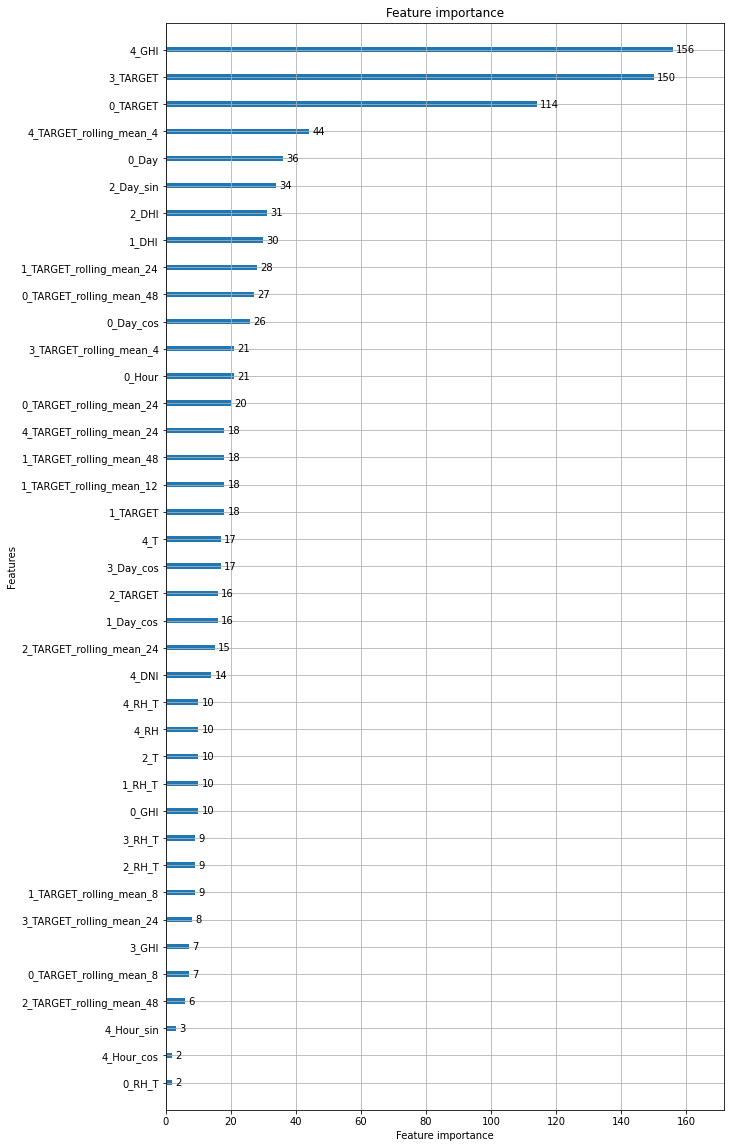

In [9]:
lgb.plot_importance(history[0][0.1]["bst_1"][0], figsize=(10, 20))

In [10]:
submission_df = load_submission_data()

result_list = history["submission_df"]
for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / index

In [11]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001200,0.000492,0.006194,0.000001


In [12]:
submission_df.to_csv(f"lightgbm_gbdt_split_dataset_2021_01_14_1_setting_index_{setting_index}.csv", index=False)